# 0.1 A minimum-snap trajectory correction for connected and autonomous vehicles

# Introduction

In this study, we propose a 2-step method for reconstructing individual longitudinal trajectories following the principles: (P1) internal consistency
among physical quantities at different orders; (P2) minimizing the mean squared errors in raw positions; (P3) bounded speeds, accelerations, jerks, and snaps; (P4) minimum-snaps driving behaviors; (P5) bounded errors in the raw positions. The method comprises two optimization problems. We first calculate the position profile that makes all higher-order physical quantities physically feasible with the least modifications in raw positions based on l2 norm minimization. Taking reference to it, we then adopt the minimum-snap theory and formulate a convex optimization problem to obtain the trajectory that leads to the minimum sum of squared snaps. P1 is reflected in differentiation, P2 helps design the objective function in step 1, P3 is reflected in the constraints of speeds, accelerations, jerks, and snaps, P4 and P5 are addressed by the objective function and the constraints of positions in step 2, respectively.

In [1]:
import pandas as pd
import io
import numpy as np
import scipy
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from matplotlib import cm
import cvxpy as cp
from cvxpy import *
 
#include different correction methods, filters and optimization functions
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.3f' % x)
np.set_printoptions(precision=3, suppress=True)#3 digit, no scientific notation
np.set_printoptions(threshold=np.inf) #no ellipses

The definitions of the variables we are going use in this manuscript are listed as below:<br>
Table 1: List of notations

|parameter | remark | parameter | remark |
| :----:| :----: | :----: | :----: |
| $t$ | Time | $T$ | Total recording duration of one vehicle |
| $\Delta t$ | Time step size | $m$ | $=t/\Delta t$, number of the time step |
| $M$ | $=M/\Delta t$, number of speed constraints | $\hat{\textbf{x}}$ | The position profile having the least errors to raw positions |  |  |
| $\tilde{\textbf{x}}$  | The minimum-snap position profile   | $l_{+}$ | The upper bound of positions |
| $v_{+}$ | The upper bound of speeds | $a_{+}$ | The upper bound of accelerations |
| $a_{-}$ | The lower bound of accelerations | $j_{+}$ | The upper bound of jerks |
| $j_{-}$ | The lower bound of jerks | $s_{+}$ | The upper bound of snaps |
| $s_{-}$ | The lower bound of snaps | $e$ | The bound of the absolute value of estimated position errors |  |  |

The terms we use in the code are listed as below: <br>
Table 2: List of each term in the code

|parameter | remark | parameter | remark |
| :----:| :----: | :----: | :----: |
| up_v | Upper bound of speed | down_v | Lower bound of speed |
| up_a | Upper bound of acceleration | down_a | Lower bound of acceleration |
| up_j | Upper bound of jerk | down_j | Lower bound of jerk |
| up_s | Upper bound of snap | down_s | Lower bound of snap |
| est_acc | Estimated accuracy | delta_t | Time step |
| uniqueness | Indicator of the formulation in step 2 (0: non-unique solution; 1: unique solution)  |

# A method for correcting longitudinal vehicle trajectories
The framework of our method is shown as Figure 1. he arrows represents the direction of the calculation, and notations can be found in Table 1. Five physical quantities, positions, speed, accelerations, jerks, and snaps, are involved in the method, the raw positions are the input and the reconstructed positions are the output. The entire process comprises two steps: (1) minimize the position errors via a l2 norm minimization problem; (2) calculate the minimum-snap trajectory. Each of them involves an optimization problem, and a detailed description of our method will be provided in the following.

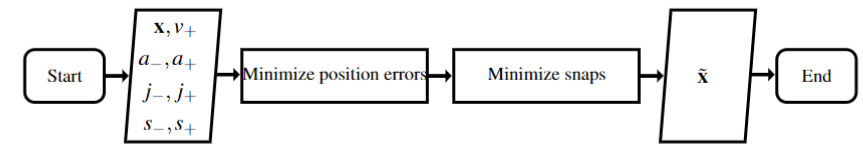

Figure 1: The framework of the method

In this study, we consider the longitudinal kinematic behaviors of vehicles. Following P1, we should guarantee the internal consistency of physical quantities among variables at different orders. We calculate speeds accelerations, jerks, and snaps by differentiating positions according to the symplectic discretization (mixed implicit-explicit Euler discretization), which was proved to be the only physically meaningful longitudinal vehicle dynamic discretization method that always leads to collision-free and forward-traveling solutions. The general discretized longitudinal kinematic motion can be illustrated by Figure 2, where black nodes represent positions $\textbf{x}$, green nodes represent speeds $\textbf{v}$, blue nodes represent accelerations $\textbf{a}$, yellow nodes represent jerks $\textbf{j}$, and magenta nodes represent snaps $\textbf{s}$. 
Arrows represent the calculation direction. $v_{m}$ is calculated with $x_{m-1}$ and $x_{m}$, $a_{m}$ is calculated with $v_{m}$ and $v_{m+1}$, $j_{m}$ is calculated with $a_{m-1}$ and $a_{m}$, $s_{m}$ is calculated with $j_{m}$ and $j_{m+1}$. There are $M+1$ discrete positions, and the lengths of corresponding speed, acceleration, jerk, and snap profiles are $M$, $M-1$, $M-2$, and $M-3$, respectively. The speed profile covers $1$ to $M$, the acceleration profile covers $1$ to $M-1$, the jerk profile starts at $2$ and ends at $M-1$, while the snap profile covers $2$ to $M-2$. 

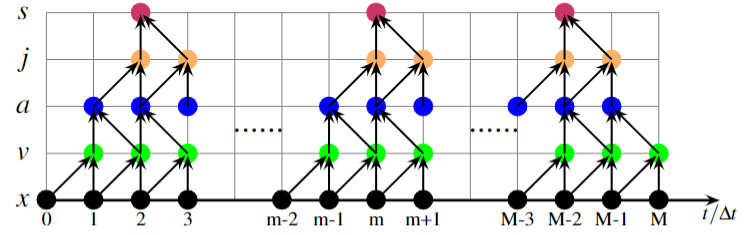

Figure 2: Illustration of descritizing longitudinal vehicle dynamic

We can calculate speeds, accelerations, jerks, and snaps with positions as follows:

$$
v_m = \frac{x_m-x_{m-1}}{\Delta t}, \ \ m=1,2,3,......,M,  (1a)
$$
$$
a_m = \frac{v_{m+1}-v_{m}}{\Delta t}=\frac{x_{m+1}-2x_{m}+x_{m-1}}{(\Delta t)^2},  \ \ m=1,2,3,......,M-1 (1b)
$$
$$
j_m = \frac{a_{m}-a_{m-1}}{\Delta t}=\frac{x_{m+1} - 3x_{m} + 3x_{m-1} - x_{m-2}}{(\Delta t)^3}, \ \ m=2,3,4,......,M-1 (1c)
$$
$$
s_m = \frac{j_{m+1} - j_m}{\Delta t} = \frac{x_{m+2} - 4x_{m+1} + 6x_{m} - 4x_{m-1} + x_{m-2}}{(\Delta t)^4}, \ \ m=2,3,4,......,M-2 (1d)
$$
where $x_m$, $v_m$, $a_m$, $j_m$ and $s_m$ are the position, speed, acceleration, jerk and snap of the vehicle at time $m\Delta t$, $M = T/\Delta t $, $T$ is the recording duration and $\Delta t$ is the time step size. Hereafter we use $m$ to represent time instant $m\Delta t$. Speeds, accelerations, jerks, and snaps are the first, second, third, and forth order derivatives of positions. Once the positions are known, speeds, accelerations, jerks, and snaps can be calculated.

In [6]:
def differentiation(lower_order, higher_order, delta_t,  order_ind):
    import copy
    if order_ind == 2 or order_ind == 4: #differentiate explicit (for accelerations and snaps)
        new_array = copy.deepcopy(lower_order);
        update_higher = copy.deepcopy(higher_order);
        update_higher[ : len(new_array)-1] = (new_array[1 : ]-new_array[ : len(new_array)-1]) / delta_t
    elif order_ind == 1 or order_ind == 3: #differentiate implicit (for speeds and jerks)
        new_array = copy.deepcopy(lower_order);
        update_higher = copy.deepcopy(higher_order);
        update_higher[ 1 : ] = (new_array[ 1 : ]-new_array[ : len(new_array)-1]) / delta_t
        
    return update_higher

## Step 1: $l_2$ norm minimization based least-smoothing trajectory

$$
 \ min \sum_{m=0}^{M} (\hat{x}_{m}-x_{m})^2, \ (2a)
$$
$$
0 \leq \hat{x}_{m} \leq l_{+}, \ \ m=0,1,2,......,M \ (2b)
$$
$$
v_{-}\leq \hat{v}_{m} \leq v_{+},  \ \ m=1,2,3,......,M \  (2c) 
$$
$$
a_{-} \leq \hat{a}_{m} \leq a_{+},  \ \ m=1,2,3,......,M-1 \ (2d)
$$
$$
j_{-} \leq \hat{j}_{m} \leq j_{+},  \ \ m=2,3,4,......,M-1 \ (2d) 
$$
$$
s_{-} \leq \hat{s}_{m} \leq s_{+}.  \ \ m=2,3,4,......,M-2 \ (2e) 
$$
where $x_m$ and $\hat{x}_{m}$ are the raw position and the least-smoothing position at time instant $m$, and $\hat{v}_{m}$, $\hat{a}_{m}$, $\hat{j}_{m}$, and $\hat{s}_m$ denote the speed, acceleration, jerk, and snap  calculated from the least-smoothing positions at time instant $m$. $l_{+}$ is the upper bound of positions, usually the length of the study site. $v_{-}$, $a_{-}$, $j_{-}$, and $s_{-}$ denote the lower bounds of speeds, accelerations, jerks, and snaps, respectively; $v_{+}$, $a_{+}$, $j_{+}$, and $s_{+}$ denote the upper bounds.


Speeds, accelerations, jerks, and snaps can be calculated with positions through (1a) to (1d). Therefore, the optimization problem can be reformulated with positions as follows:

$$
 \ min \sum_{m=0}^{M} (\hat{x}_{m}-x_{m})^2 ,  \ (3a)
$$
$$
0 \leq \hat{x}_{m} \leq l_{+}, \ \ m=0,1,2,......,M \ (3b)
$$
$$
v_{-}\leq \frac{\hat{x}_m-\hat{x}_{m-1}}{\Delta t} \leq v_{+},  \ \ m=1,2,3,......,M \  (3c) 
$$
$$
a_{-}\leq \frac{\hat{x}_{m+1}-2\hat{x}_{m}+\hat{x}_{m-1}}{(\Delta t)^2} \leq a_{+},  \ \ m=1,2,3,......,M-1 \ (3d)
$$
$$
j_{-}\leq \frac{\hat{x}_{m+1} - 3\hat{x}_{m} + 3\hat{x}_{m-1} - \hat{x}_{m-2}}{(\Delta t)^3} \leq j_{+},  \ \ m=2,3,4,......,M-1 \ (3d) 
$$
$$
s_{-} \leq \frac{\hat{x}_{m+2} - 4\hat{x}_{m+1} + 6\hat{x}_{m} - 4\hat{x}_{m-1} + \hat{x}_{m-2}}{(\Delta t)^4} \leq s_{+}.  \ \ m=2,3,4,......,M-2 \ (3e) 
$$

## Step 2: minimum-snap trajectory
As pointed out by P4 that people tend to drive in a manner that can lead to the minimum snaps, and P5 that errors in raw positions should be bounded by the estimated accuracy, we generate a minimum-snap trajectory using the least-smoothing trajectory as a reference. The optimization problem can be written as follows:

$$
  \min{ \sum_{m=2}^{M-2} \tilde{s}_m^2 }, \ (4a)
$$
$$
x^*_{-,m} \leq \tilde{x}_{m} \leq x^*_{+,m}, \ \ m=0,1,2,......,M \ (4b)
$$
$$
v_{-}\leq \tilde{v}_{m} \leq v_{+},  \ \ m=1,2,3,......,M \  (4c) 
$$
$$
a_{-} \leq \tilde{a}_{m} \leq a_{+},  \ \ m=1,2,3,......,M-1 \ (4d)
$$
$$
j_{-} \leq \tilde{j}_{m} \leq j_{+},  \ \ m=2,3,4,......,M-1 \ (4e) 
$$

$$
x^*_{-,m} = \min\{x_m - e, \hat{x}_m\}, \ (5a)
$$
$$
x^*_{+,m} = \max\{x_m + e, \hat{x}_m\}, \ (5b)
$$
where $\tilde{s} $ is the reconstructed snap which can indicate the rate of change of the jerk with respect to time, and the objective function is to minimize the sum of squared snaps. $x^*_{-,m}$ and $x^*_{+,m}$ are the low and upper bounds of positions at time instant $m$, which can be calculated with raw positions $x_m$, least-smoothing positions $\hat{x}_{m}$, and the claimed estimated accuracy $e$ via (5a) and (5b). The bounds of speeds, accelerations, and jerks are the same as those in section 2.1.

In [18]:
def position_limit(raw_x, id, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc): 
    #the input are the raw positions, and the outputs are lower bound and the upper bound of the position
    import copy
    M = len(raw_x) - 1
    new_x, raw_pos, pos_model = reconstruct_traj_l2(raw_x, id, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t); #calculate the reconstructed positions based on l_2 norm minimization
    raw_up = raw_x + est_acc; raw_down = raw_x - est_acc #upper and lower limit of the raw position, if it is a feasible region, then this is the position constraint
    upper_x = np.maximum(raw_x + est_acc, new_x); lower_x = np.minimum(raw_x - est_acc, new_x)
    return upper_x, lower_x, new_x

Integration can be regarded as an inversed procedure of (1a) to (1d), as shown by Figure 3, black, green, blue, yellow, and magenta nodes represent positions, speeds, accelerations, jerks, and snaps, respectively. The snaps, as well as the initial jerk, acceleration, speed, and position are shown with solid nodes. We use the last position as an example. As shown by the red node in Figure 3, $j_{M-1}$ can be calculated with the initial jerk and the snaps from $2$ to $M-2$ (the entire snap profile). Similarly, $a_{M-1}$ can be calculated with the initial acceleration and the jerk profile, $v_{M}$ can be calculated with the initial speed and the acceleration profile, and $x_{M}$ can be calculated with the initial position and the speed profile. That is, $x_{M}$ can be calculated with the initial position, speed, acceleration, jerk, and the entire snap profile. Therefore, with snaps, as well as the initial jerk, acceleration, speed, and position, all physical quantities can be calculated. 



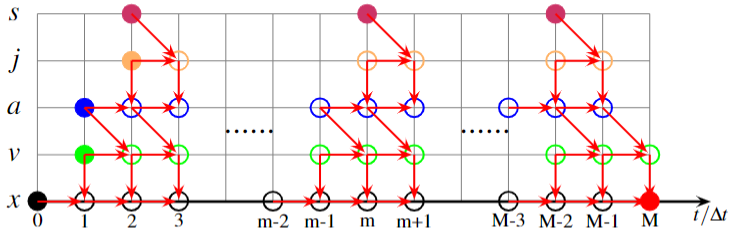

Figure 3: Illustration of integrating snaps to positions

Replacing the lower-order physical quantities with snaps and initial states, the minimum-snap trajectory can be written as follows:

$$
  \min{ \sum_{m=2}^{M-2} \tilde{s}_m^2 }, \ (4a)
$$
$$
x^*_{min,m} \leq \tilde{x}_0 + m\tilde{v}_1 \Delta t + \frac{m(m-1)}{2} \tilde{a}_{1} \Delta t^2 + \frac{m(m-1)(m-2)}{6} \tilde{j}_{2} \Delta t^3 \\ + \Delta t^4 \sum_{\delta=2}^{m-2} \frac{(m-\delta+1)(m-\delta)(m-\delta -1)}{6} \tilde{s}_{\delta} \leq x^*_{max,m}, \ \ m=1,2,...,M \ (6b) 
$$
$$
v_{min}\leq \tilde{v}_{1} + (m-1)\tilde{a}_{1} \Delta t + \frac{(m-1)(m-2)}{2} \tilde{j}_{2} \Delta t^2 \\ + \Delta t^3 \sum_{\delta=2}^{m-2} \frac{(m-\delta)(m-\delta -1)}{2} \tilde{s}_{\delta} \leq v_{max}, \ \ m=2,3,...,M, \  (6c) 
$$
$$
a_{min}\leq \tilde{a}_{1} + (m-1)\tilde{j}_{2} \Delta t + \Delta t^2 \sum_{\delta =2}^{m-1} (m-\delta)\tilde{s}_{\delta} \leq s_{max}, \ \ m=2,3,...,M-1 \ (6d) 
$$
$$
j_{-}\leq \tilde{j}_{2} + \Delta t \sum_{\delta = 2}^{m-1} \tilde{s}_{\delta}  \leq j_{+}, \ \ m=3,4,...,M-1 \ (6e) 
$$

# Optimization problems analysis


## Analysis of the coefficient matrix
The least-smoothing optimization problem (3) can be written in matrices:
$$
  \min{||\hat{\textbf{x}}-\textbf{x}||}, \ (7a)
$$
$$
-\hat{\textbf{x}} \leq \textbf{0}, \ (7b) 
$$
$$
\hat{\textbf{x}} \leq \textbf{l}_{\textbf{+}}, \  (7c) 
$$
$$
-W_{(1)}\hat{\textbf{x}} \leq \textbf{0}, \ (7d) 
$$
$$
W_{(1)}\hat{\textbf{x}} \leq \textbf{v}_{\textbf{+}} \Delta t, \ (7e) 
$$
$$
-W_{(2)}\hat{\textbf{x}} \leq -\textbf{a}_{\textbf{-}} \Delta t^2, \ (7f) 
$$
$$
W_{(2)}\hat{\textbf{x}} \leq \textbf{a}_{\textbf{+}} \Delta t^2, \  (7g) 
$$
$$
-W_{(3)}\hat{\textbf{x}} \leq -\textbf{j}_{\textbf{-}} \Delta t^3, \ (7h) 
$$
$$
W_{(3)}\hat{\textbf{x}} \leq \textbf{j}_{\textbf{+}} \Delta t^3, \ (7i) 
$$
$$
-W_{(4)}\hat{\textbf{x}} \leq -\textbf{s}_{\textbf{-}} \Delta t^4, \ (7j) 
$$
$$
W_{(4)}\hat{\textbf{x}} \leq \textbf{s}_{\textbf{+}} \Delta t^4, \ (7k) 
$$

\begin{matrix}
W_{(1),M,M+1}=
\begin{bmatrix}
-1 & 1 & 0 & \cdots & 0 & 0 & 0\\
0 & -1 & 1 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & \cdots & -1 & 1 & 0 \\
0 & 0 & 0 & \cdots & 0 & -1 & 1 \\
\end{bmatrix}
&
W_{(2),M-1,M+1}=
\begin{bmatrix}
1 & -2 & 1 & \cdots & 0 & 0 & 0\\
0 & 1 & -2 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & \cdots & -2 & 1 & 0 \\
0 & 0 & 0 & \cdots & 1 & -2 & 1 \\
\end{bmatrix}
\end{matrix}

\begin{matrix}
W_{(3),M-2,M+1}=
\begin{bmatrix}
-1 & 3 & -3 & 1 &\cdots & 0 & 0 & 0 & 0 \\
0 & -1 & 3 & -3 &\cdots & 0 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & 0 & \cdots & 3 & -3 & 1 & 0 \\
0 & 0 & 0 & 0 & \cdots & -1 & 3 & -3 & 1 \\
\end{bmatrix}
&
W_{(4),M-3,M+1}=
\begin{bmatrix}
1 & -4 & 6 & -4 & 1 &\cdots & 0 & 0 & 0 & 0 &0\\
0 & 1 & -4 & 6 & -4 &\cdots & 0 & 0 & 0 & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & 0 & 0 & \cdots & -4 & 6 & -4 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & \cdots & 1 & -4 & 6 & -4 & 1 \\
\end{bmatrix}
\end{matrix}
where $M+1$ is the number of positions in one trajectory. $W_{(1)}, W_{(2)}, W_{(3)}$, and $W_{(4)}$ are the coefficient matrices for speeds, accelerations, jerks, and snaps; They have staircase structures and are referred to as the first, second, third, and fourth difference matrices, respectively

In [17]:
def reconstruct_traj_l2(raw_x, id, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t): # the input is the raw position, speed bounds, acceleration bounds, jerk bounds, snap bounds
    M = len(raw_x) - 1
    x = cp.Variable(M+1) #Define variables
    # coefficient matrix
    W0_0 = -np.identity(M+1); W0_1 = np.identity(M+1); W1 = np.zeros((2*M,M+1)); W2 = np.zeros((2*M-2,M+1)); W3 = np.zeros((2*M-4,M+1)); W4 = np.zeros((2*M-6,M+1)); W5 = np.zeros((2*M+2,M+1)); 
    for i in range(M):
        W1[i,i] = 1; W1[i,i+1] = -1; W1[i+M,i] = -1; W1[i+M,i+1] = 1
    for i in range(M-1):
        W2[i,i] = -1; W2[i,i+1] = 2; W2[i,i+2] = -1; W2[i+(M-1),i] = 1; W2[i+(M-1),i+1] = -2; W2[i+(M-1),i+2] = 1
    for i in range(M-2):
        W3[i,i] = 1; W3[i,i+1] = -3; W3[i,i+2] = 3; W3[i,i+3] = -1; W3[i+(M-2),i] = -1; W3[i+(M-2),i+1] = 3; W3[i+(M-2),i+2] = -3; W3[i+(M-2),i+3] = 1
    for i in range(M-3):
        W4[i,i] = -1; W4[i,i+1] = 4; W4[i,i+2] = -6; W4[i,i+3] = 4; W4[i,i+4] = -1; W4[i+(M-3),i] = 1; W4[i+(M-3),i+1] = -4; W4[i+(M-3),i+2] = 6; W4[i+(M-3),i+3] = -4; W4[i+(M-3),i+4] = 1    
    coe_l = np.vstack( (W0_0,W0_1,W1,W2,W3,W4) );  #coefficient matrix of constraints
    # right side of constraints
    coe_r = np.vstack( ( np.array([0]*(M+1)).reshape(M+1,1), np.array([550]*(M+1)).reshape(M+1,1), np.array([0]*M).reshape(M,1), np.array([up_v*delta_t]*M).reshape(M,1), np.array([-down_a*(delta_t**2)]*(M-1)).reshape((M-1),1), 
                np.array([up_a*(delta_t**2)]*(M-1)).reshape((M-1),1), np.array([-down_j*(delta_t**3)]*(M-2)).reshape((M-2),1), np.array([up_j*(delta_t**3)]*(M-2)).reshape((M-2),1), 
                np.array([-down_s*(delta_t**4)]*(M-3)).reshape((M-3),1), np.array([up_s*(delta_t**4)]*(M-3)).reshape((M-3),1) ) ).reshape(10*M-10,) #right side of constraints
    #objective function
    obj = cp.sum_squares(x - raw_x)
    #constraints, AX <= b
    cons = [coe_l @ x <= coe_r]
    #print(cons)
    model = cp.Problem(cp.Minimize(obj), cons)
    #solve the model
    model.solve(solver=cp.ECOS, max_iters = 1000, abstol = 10**(-9), reltol = 10**(-9))
    new_x = x.value; pos_array = np.array(raw_x).reshape(len(raw_x),1) #reconstructed positions and raw_positions
    
    return new_x, pos_array, model 

From Figure 2 we can know that each snap can be calculated with only five positions. However, from Figure 3, we can see that to calculate a position, we need the initial position, speed, acceleration, and jerk, and all previous snaps. To calculate the last position, for example, we need the initial position, speed, acceleration, and jerk, and M − 2 snaps. Therefore, if we write the minimum-snap problem with the positions as variables, the coefficient
matrix will be much more sparse, which can greatly reduce the computation cost. This part is detailed discussed in the paper, thus we omit it here. The minimum-snap trajectory can be rewritten as follows:

$$
  \min{(W_{(4)}\tilde{\textbf{x}})^T (W_{(4)}\tilde{\textbf{x}})}, \ (12a)
$$
$$
-\tilde{\textbf{x}} \leq -\textbf{x}^*_{\textbf{-}}, \ (12b) 
$$
$$
\tilde{\textbf{x}} \leq \textbf{x}^*_{\textbf{+}}, \  (12c) 
$$
$$
-W_{(1)}\tilde{\textbf{x}} \leq \textbf{0}, \ (12d)
$$
$$
W_{(1)}\tilde{\textbf{x}} \leq \textbf{v}_{\textbf{+}} \Delta t, \ (12e) 
$$
$$
-W_{(2)}\tilde{\textbf{x}} \leq -\textbf{a}_{\textbf{-}} \Delta t^2, \ (12f) 
$$
$$
W_{(2)}\tilde{\textbf{x}} \leq \textbf{a}_{\textbf{+}} \Delta t^2, \  (12g) 
$$
$$
-W_{(3)}\tilde{\textbf{x}} \leq -\textbf{j}_{\textbf{-}} \Delta t^3, \ (12h) 
$$
$$
W_{(3)}\tilde{\textbf{x}} \leq \textbf{j}_{\textbf{+}} \Delta t^3, \ (12i) 
$$
where $W_{(1)}, W_{(2)}, W_{(3)}$ are the same as those in (7d) to (7i)

In addition, if we assume that the initial position, speed, acceleration, and jerk are known and equal to the output of step one, that is, $\tilde{x}_{0} = \hat{x}_0, \tilde{v}_1 = \hat{v}_{1}, \tilde{a}_1 = \hat{a}_{1}$, and $\tilde{j}_2 = \hat{j}_{2}$. From (1a) to (1d) we can see that this is equivalent to assuming the first four positions are given, and we can rewrite step 2 as follows:
$$
  \min{(G_{(4)} \tilde{\textbf{x}}_{4:M} + \gamma_{(4)})^T (G_{(4)}\tilde{\textbf{x}}_{4:M} + \gamma_{(4)})}, \ (13a)
$$

$$
- \tilde{\textbf{x}}_{4:M} \leq -\textbf{x}^*_{\textbf{-},4:M}, \ (13b) 
$$
$$
\tilde{\textbf{x}}_{4:M} \leq \textbf{x}^*_{\textbf{+},4:M}, \  (13c) 
$$
$$
-(G_{(1)}\tilde{\textbf{x}}_{4:M}+\gamma_{(1)}) \leq \textbf{0} \Delta t, \ (12d) 
$$
$$
(G_{(1)}\tilde{\textbf{x}}_{4:M}+\gamma_{(1)}) \leq \textbf{v}_{\textbf{+}} \Delta t, \ (13e) 
$$
$$
-(G_{(2)}\tilde{\textbf{x}}_{4:M}+\gamma_{(2)}) \leq -\textbf{a}_{\textbf{-}} \Delta t^2, \ (13f) 
$$
$$
(G_{(2)}\tilde{\textbf{x}}_{4:M}+\gamma_{(2)}) \leq \textbf{a}_{\textbf{+}} \Delta t^2, \  (13g) 
$$
$$
-(G_{(3)}\tilde{\textbf{x}}_{4:M}+\gamma_{(3)}) \leq -\textbf{j}_{\textbf{-}} \Delta t^3, \ (13h) 
$$
$$
(G_{(3)}\tilde{\textbf{x}}_{4:M}+\gamma_{(3)}) \leq \textbf{j}_{\textbf{+}} \Delta t^3, \ (13i) 
$$



\begin{matrix}
G_{(1),M-3,M-3}=
\begin{bmatrix}
1 & 0 & 0 & \cdots & 0 & 0 & 0\\
-1 & 1 & 0 & \cdots & 0 & 0 & 0 \\
0 & -1 & 1 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & \cdots & 0 & -1 & 1 \\
\end{bmatrix}
&
G_{(2),M-3,M-3}=
\begin{bmatrix}
1 & 0 & 0 & \cdots & 0 & 0 & 0\\
-2 & 1 & 0 & \cdots & 0 & 0 & 0 \\
1 & -2 & 1 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & \cdots & 1 & -2 & 1 \\
\end{bmatrix}
\end{matrix}

\begin{matrix}
G_{(3),M-3,M-3}=
\begin{bmatrix}
1 & 0 & 0 & 0 &\cdots & 0 & 0 & 0 & 0 \\
-3 & 1 & 0 & 0 &\cdots & 0 & 0 & 0 & 0 \\
3 & -3 & 1 & 0 & \cdots & 3 & -3 & 1 & 0 \\
-1 & 3 & -3 & 1 & \cdots & 3 & -3 & 1 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & 0 & \cdots & -1 & 3 & -3 & 1 \\
\end{bmatrix}
&
G_{(4),M-3,M-3}=
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 &\cdots & 0 & 0 & 0 & 0 &0\\
-4 & 1 & 0 & 0 & 0 &\cdots & 0 & 0 & 0 & 0 & 0\\
6 & -4 & 1 & 0 & 0 &\cdots & 0 & 0 & 0 & 0 &0\\
-4 & 6 & -4 & 1 & 0 &\cdots & 0 & 0 & 0 & 0 & 0\\
1 & -4 & 6 & -4 & 1 & \cdots & 0 & 0 & 0 & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & 0 & 0 & \cdots & 1 & -4 & 6 & -4 & 1 \\
\end{bmatrix}
\end{matrix}

\begin{matrix}
\gamma_{(1)}=
\begin{bmatrix}
-\hat{x}_3 \\
0 \\
0 \\
0 \\
0 \\
\vdots \\
0
\end{bmatrix}
&
\gamma_{(2)}=
\begin{bmatrix}
\hat{x}_2-2\hat{x}_3 \\
\hat{x}_3 \\
0 \\
0 \\
0 \\
\vdots \\
0
\end{bmatrix}
&
\gamma_{(3)}=
\begin{bmatrix}
-\hat{x}_1+3\hat{x}_2-3\hat{x}_3 \\
-\hat{x}_2+3\hat{x}_3 \\
-\hat{x}_3 \\
0 \\
0 \\
\vdots \\
0
\end{bmatrix}
&
\gamma_{(3)}=
\begin{bmatrix}
\hat{x}_0-4\hat{x}_1+6\hat{x}_2-4\hat{x}_3 \\
\hat{x}_1-4\hat{x}_2+6\hat{x}_3 \\
\hat{x}_2-4\hat{x}_3 \\
\hat{x}_3 \\
0 \\
\vdots \\
0
\end{bmatrix}
\end{matrix}
where $\tilde{\textbf{x}}_{4:M}$ denotes the vector $[\tilde{x}_{4},\tilde{x}_{5},\tilde{x}_{6},...,\tilde{x}_{M}]^T $.

For the above two formulations, (12a) to (12i) can lead to multiple solutions while (13a) to (13i) can lead to a unique solution. Detailed provement can be found in the paper, and we omit it here.

In [19]:
def reconstruct_traj_minsnap(raw_x, id, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, uniqueness): # the input is the raw position, speed bounds, acceleration bounds, jerk bounds, snap bounds
    M = len(raw_x) - 1
    x = cp.Variable(M+1) #Define variables
    pos_up, pos_down, l2_pos = position_limit(raw_x, id, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc) #lower bound and upper bound of positions
    # coefficient matrix
    W0_0 = -np.identity(M+1); W0_1 = np.identity(M+1); W1 = np.zeros((2*M,M+1)); W2 = np.zeros((2*M-2,M+1)); W3 = np.zeros((2*M-4,M+1)); W4 = np.zeros((2*M-6,M+1)); W5 = np.zeros((2*M+2,M+1)); 
    for i in range(M):
        W1[i,i] = 1; W1[i,i+1] = -1; W1[i+M,i] = -1; W1[i+M,i+1] = 1
    for i in range(M-1):
        W2[i,i] = -1; W2[i,i+1] = 2; W2[i,i+2] = -1; W2[i+(M-1),i] = 1; W2[i+(M-1),i+1] = -2; W2[i+(M-1),i+2] = 1
    for i in range(M-2):
        W3[i,i] = 1; W3[i,i+1] = -3; W3[i,i+2] = 3; W3[i,i+3] = -1; W3[i+(M-2),i] = -1; W3[i+(M-2),i+1] = 3; W3[i+(M-2),i+2] = -3; W3[i+(M-2),i+3] = 1
    for i in range(M-3):
        W4[i,i] = 1/(delta_t**1); W4[i,i+1] = -4/(delta_t**1); W4[i,i+2] = 6/(delta_t**1); W4[i,i+3] = -4/(delta_t**1); W4[i,i+4] = 1/(delta_t**1)
    coe_l = np.vstack( (W0_0,W0_1,W1,W2,W3) ); #coefficient matrix of constraints
    # right side of constraints
    coe_r = np.vstack( ( -pos_down.reshape(M+1,1), pos_up.reshape(M+1,1), np.array([0]*M).reshape(M,1), np.array([up_v*delta_t]*M).reshape(M,1), np.array([-down_a*(delta_t**2)]*(M-1)).reshape((M-1),1), 
            np.array([up_a*(delta_t**2)]*(M-1)).reshape((M-1),1),  np.array([-down_j*(delta_t**3)]*(M-2)).reshape((M-2),1), np.array([up_j*(delta_t**3)]*(M-2)).reshape((M-2),1) ) ).reshape(8*M-4,) #right side of constraints
    #objective function
    obj = cp.sum_squares(W4 @ x)
    #constraints, AX <= b
    if uniqueness == 0: #non-unique condition
        cons = [coe_l @ x <= coe_r]
    elif uniqueness == 1: #unique condition
        cons = [coe_l @ x <= coe_r, x[0] == l2_pos[0], x[1] == l2_pos[1], x[2] == l2_pos[2], x[3] == l2_pos[3]] #keep the first 4 values of \hat{x}
    model = cp.Problem(cp.Minimize(obj), cons)
    #solve the model
    model.solve(solver=cp.ECOS, max_iters = 100000, abstol = 10**(-9), reltol = 10**(-9))
    print("status",model.status,"\nThe optimal value is", model.value)
    new_x = x.value; pos_array = np.array(raw_x).reshape(len(raw_x),1); l2_pos = l2_pos.reshape(len(l2_pos),1) #reconstructed positions and raw_positions
        
    return new_x, l2_pos, pos_array, model 

Then we can calculated the higher order derivatives with the positions reconstructed using our method.

In [20]:
def higher_order_calc_pos(old_matrix, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, uniqueness):
    new_array_np = old_matrix.values
    id_set = sorted(set(new_array_np[:,0].tolist()),key = new_array_np[:,0].tolist().index)#pick out all the ids, and create a list to store them
    print("id_set",id_set)
    cal_array = np.zeros((1,17)); cal_array_l2 = np.zeros((1,17))
    for n_id in range(len(id_set)):
        new_matrix = new_array_np[np.where(new_array_np[:,0] == id_set[n_id] )]; new_matrix_l2 = new_array_np[np.where(new_array_np[:,0] == id_set[n_id] )]
        #print('n_id',id_set[n_id],"new_matrix", new_matrix)
        raw_pos = new_matrix[:,-10] #np.array([1.002,1.002,1.002,1.002,1.002]) #raw_position
        new_pos, least_smooth_pos, original_pos, model_pos = reconstruct_traj_minsnap(raw_pos, id_set[n_id], down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, uniqueness)
        new_pos = new_pos.reshape(len(raw_pos),1)
        #least change positions and higher order derivatives
        new_matrix_l2[:,-5] = least_smooth_pos[:,0];
        new_matrix_l2[1:,-4] =   differentiation(new_matrix_l2[:,-5], new_matrix_l2[:,-9], delta_t,  order_ind = 1)[1:] #(least_smooth_pos[1:,0]-least_smooth_pos[0:-1,0])/delta_t #speed implicit
        new_matrix_l2[1:-1,-3] = differentiation(new_matrix_l2[:,-4], new_matrix_l2[:,-8], delta_t,  order_ind = 2)[1:-1] #(least_smooth_pos[2:,0] - 2*least_smooth_pos[1:-1,0] + least_smooth_pos[:-2,0])/(delta_t**2) #acceleration explicit
        new_matrix_l2[2:-1,-2] = differentiation(new_matrix_l2[:,-3], new_matrix_l2[:,-7], delta_t,  order_ind = 3)[2:-1] #(least_smooth_pos[3:,0] - 3*least_smooth_pos[2:-1,0] + 3*least_smooth_pos[1:-2,0] - least_smooth_pos[:-3,0])/(delta_t**3) #jerk implicit
        new_matrix_l2[2:-2,-1] = differentiation(new_matrix_l2[:,-2], new_matrix_l2[:,-6], delta_t,  order_ind = 4)[2:-2] #(least_smooth_pos[4:,0] - 4*least_smooth_pos[3:-1,0] + 6*least_smooth_pos[2:-2,0] - 4*least_smooth_pos[1:-3,0] + least_smooth_pos[:-4,0])/(delta_t**4) #snap explicit
        cal_array_l2 = np.vstack((cal_array_l2, new_matrix_l2[2:-2]))
        #final positions and higher order derivatives
        new_matrix[:,-5] = new_pos[:,0]; 
        new_matrix[1:,-4] =  differentiation(new_matrix[:,-5], new_matrix[:,-9], delta_t,  order_ind = 1)[1:]  #(new_pos[1:,0]-new_pos[0:-1,0])/delta_t #speed implicit
        new_matrix[1:-1,-3] = differentiation(new_matrix[:,-4], new_matrix[:,-8], delta_t,  order_ind = 2)[1:-1] #(new_pos[2:,0] - 2*new_pos[1:-1,0] + new_pos[:-2,0])/(delta_t**2) #acceleration explicit
        new_matrix[2:-1,-2] = differentiation(new_matrix[:,-3], new_matrix[:,-7], delta_t,  order_ind = 3)[2:-1] #(new_pos[3:,0] - 3*new_pos[2:-1,0] + 3*new_pos[1:-2,0] - new_pos[:-3,0])/(delta_t**3) #jerk implicit
        new_matrix[2:-2,-1] = differentiation(new_matrix[:,-2], new_matrix[:,-6], delta_t,  order_ind = 4)[2:-2] #(new_pos[4:,0] - 4*new_pos[3:-1,0] + 6*new_pos[2:-2,0] - 4*new_pos[1:-3,0] + new_pos[:-4,0])/(delta_t**4) #snap explicit
        cal_array = np.vstack((cal_array, new_matrix[2:-2])) #[2:-2]
        pos_error = np.mean(np.abs(new_matrix[2:-2, -10] - new_matrix[2:-2, -5])); 
        obj = np.sum(new_matrix[2:-2, -1]**2); print("id", n_id ,"pos_error", pos_error, "obj", obj) #calculate the MAE between raw and reconstructed trajectory
    cal_array = cal_array[1: ]; cal_array_l2 = cal_array_l2[1: ]
    pos_error = np.mean(np.abs(cal_array[:,-10]-cal_array[:,-5])); print("pos_error", pos_error, "$m$") #calculate the MAE between raw and reconstructed trajectory
    #max_pos = max(np.abs(cal_array[:,-10]-cal_array[:,-5])); print("max pos_error", max_pos, "$m$")
    return cal_array, cal_array_l2

# Calibration and validation with the NGSIM data
We first import the sample data.

In [7]:
#from google.colab import files
#uploaded = files.upload()
veh_traj = pd.read_csv('veh973.csv', usecols = ['Vehicle_ID','Frame_ID','Global_Time','Local_Y','Lane_ID', 'Preceding','Following'])

#change time to second
veh_traj['Global_Time'] = veh_traj['Global_Time'] * 0.001
for item in ['Local_Y']: #Change the unit from ft/s to m/s
    veh_traj[item] = veh_traj[item]*0.3048
#add 8 columns at the end, called "distance", "velocity", "acceleration", and "jerk"
veh_traj['distance'] = 0
veh_traj['velocity'] = 0
veh_traj['acceleration'] = 0 
veh_traj['jerk'] = 0 
veh_traj['snap'] = 0
veh_traj['smooth_x'] = 0
veh_traj['smooth_v'] = 0
veh_traj['smooth_a'] = 0
veh_traj['smooth_j'] = 0
veh_traj['smooth_s'] = 0

Saving veh973.csv to veh973 (1).csv


## Parameter settings
Prior to applying our method, we need to determine the ranges of each physical quantity and the bound of position errors. According to the features of the NGSIM datasets, the bounds of the estimated absolute position errors should be $1.2m$, and we choose the length of the study site ($504$ meters for the I80 freeway and $488$ meters for the Lankershim blvd) as the upper bounds for positions. Considering the speed limits are 65mph ($28.9m/s$) on the I80 freeway and 35mph ($15.5m/s$) on the Lankershim blvd, we choose $[0,30]m/s$ and $[0,20]m/s$ as the speed ranges, respectively. Taking reference of previous studies, for both conditions, we choose $[-4,5]m/s^2$ as the acceleration range, $[-15,15]m/s^3$ as the jerk range, and $[-30,30]m/s^4$ as the snap range.

## Calibration with the sample trajectory

We choose vehicle 973 in the NGSIM Lankershim blvd dataset as the sample trajectory to apply our method.

In [15]:
def method_application(raw_traj, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, uniqueness):
    original_array = raw_traj.values
    import copy
    new_array_np = copy.deepcopy(original_array); cal_array = np.zeros((1,17));
    id_set = sorted(set(new_array_np[:,0].tolist()),key = new_array_np[:,0].tolist().index)#pick out all the ids, and create a list to store them
    for n_id in range(len(id_set)): #go over each vehicle
        new_array = new_array_np[np.where(new_array_np[:,0] == id_set[n_id] )] 
        new_array[:,-10] = np.absolute(new_array[:,3] - new_array[0,3]) + 4 #moving distance 
        new_array[:,2] = (new_array[:,1] - new_array[0,1]) * delta_t #time 
        new_array[1:,-9] = differentiation(new_array[:,-10], new_array[:,-9], delta_t,  order_ind = 1)[1:] #speed implicit, Eq 1a
        new_array[1:-1,-8] = differentiation(new_array[:,-9], new_array[:,-8], delta_t,  order_ind = 2)[1:-1] #acceleration explicit, Eq 1b
        new_array[2:-1,-7] = differentiation(new_array[:,-8], new_array[:,-7], delta_t,  order_ind = 3)[2:-1] #jerk implicit, Eq 1c
        new_array[2:-2,-6] = differentiation(new_array[:,-7], new_array[:,-6], delta_t,  order_ind = 4)[2:-2] #snap explicit, Eq 1d

        cal_array = np.vstack((cal_array, new_array));
    veh_update = pd.DataFrame(copy.deepcopy(cal_array[1:]));
    smooth_veh2, smooth_veh1 = higher_order_calc_pos(veh_update[:], down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, uniqueness)

    return smooth_veh2, smooth_veh1

In [16]:
down_vel = 0; up_vel = 20; down_acc = -5; up_acc = 4; down_jerk = -15; up_jerk = 15; down_snap = -30; up_snap = 30; delta_t = 0.1; est_acc = 1.2; unique = 1; non_unique = 0
smooth_veh, smooth_veh_l2 = method_application(veh_traj, down_vel, up_vel, down_acc, up_acc, down_jerk, up_jerk, down_snap, up_snap, delta_t, est_acc, unique)
smooth_veh_non, smooth_veh_l2 = method_application(veh_traj, down_vel, up_vel, down_acc, up_acc, down_jerk, up_jerk, down_snap, up_snap, delta_t, est_acc, non_unique)

id_set [973.0]


/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1338: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


status optimal 
The optimal value is 0.011044696255679862
id 0 pos_error 0.6562566390890294 obj 11044.696255940587
pos_error 0.6562566390890294 $m$
id_set [973.0]
status optimal 
The optimal value is 0.008187231642357018
id 0 pos_error 0.625942524486242 obj 8187.231642371231
pos_error 0.625942524486242 $m$


We plot the positions, speeds, accelerations, and jerks before and after reconstruction.

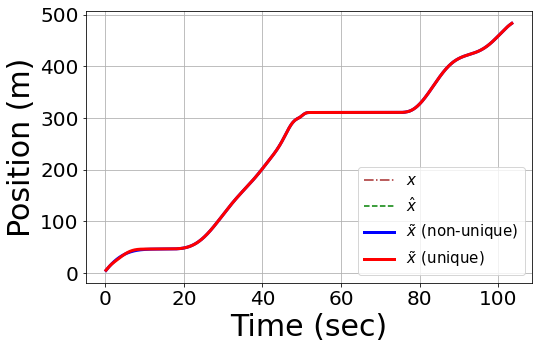

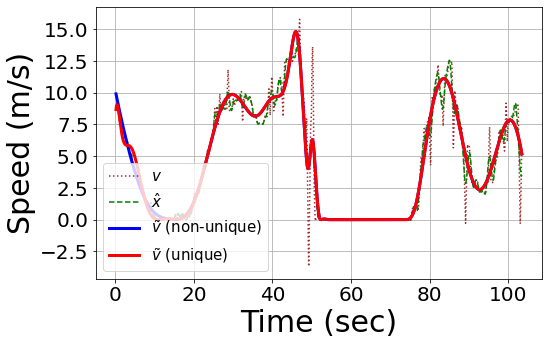

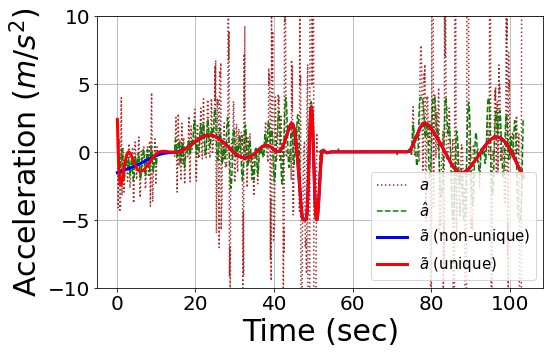

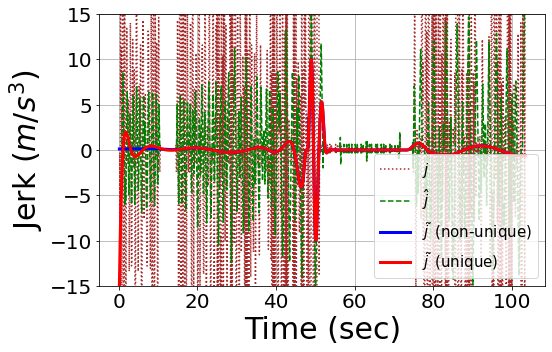

In [24]:
import matplotlib.pyplot as plt
font1 = 15; lo = 4; line = 1.5; line2 = 3
font2 = {'family' : 'DejaVu Sans', 'weight' : 'normal', 'size' : 30,}

plt.figure(figsize=(8,5));
plt.figure(1)
plt.ylabel("Position (m)",font2); plt.xlabel("Time (sec)",font2)
plt.xticks(fontsize=20); plt.yticks(fontsize=20)
plt.plot(smooth_veh[:,2],smooth_veh[:,-10], color = "brown", linewidth=line, linestyle='-.', label = "$x$"); 
plt.plot(smooth_veh_l2[:,2],smooth_veh_l2[:,-5],  color = "g", linewidth=line, linestyle='--', label = "$\hat{x}$")
plt.plot(smooth_veh_non[:,2],smooth_veh_non[:,-5], color = "b", linewidth= line2, label = "$\~x$ (non-unique)");
plt.plot(smooth_veh[:,2],smooth_veh[:,-5], color = "r", linewidth= line2, label = "$\~x$ (unique)");
plt.grid(); plt.legend(fontsize=font1, loc = lo); plt.show()

plt.figure(figsize=(8,5)); 
plt.figure(2)
plt.ylabel("Speed (m/s)",font2); plt.xlabel("Time (sec)",font2)
plt.xticks(fontsize=20); plt.yticks(fontsize=20) 
plt.plot(smooth_veh[:,2],smooth_veh[:,-9], color = "brown", linewidth=line, linestyle=':', label = "$v$"); 
plt.plot(smooth_veh_l2[:,2],smooth_veh_l2[:,-4], color = "g", linewidth=line, linestyle='--', label = "$\hat{x}$")
plt.plot(smooth_veh_non[:,2],smooth_veh_non[:,-4], color = "b", linewidth= line2, label = "$\~v$ (non-unique)");
plt.plot(smooth_veh[:,2],smooth_veh[:,-4], color = "r", linewidth= line2, label = "$\~v$ (unique)");
plt.grid(); plt.legend(fontsize=font1, loc = 3); plt.show()


plt.figure(figsize=(8,5)); plt.ylim(-10,10)
plt.figure(3)
plt.ylabel("Acceleration ($m/s^2$)",font2); plt.xlabel("Time (sec)",font2) 
plt.xticks(fontsize=20); plt.yticks(np.arange(-10,12,5),fontsize=20)
plt.plot(smooth_veh[:,2],smooth_veh[:,-8], color = "brown", linewidth=line, linestyle=':', label = "$a$"); 
plt.plot(smooth_veh_l2[:,2],smooth_veh_l2[:,-3], color = "g", linewidth=line, linestyle='--', label = "$\hat{a}$");
plt.plot(smooth_veh_non[:,2],smooth_veh_non[:,-3], color = "b", linewidth= line2, label = "$\~a$ (non-unique)");
plt.plot(smooth_veh[:,2],smooth_veh[:,-3], color = "r", linewidth= line2, label = "$\~a$ (unique)");
plt.grid(); plt.legend(fontsize=font1, loc = lo); plt.show()

plt.figure(figsize=(8,5)); plt.ylim(-15,15)
plt.figure(4)
plt.ylabel("Jerk ($m/s^3$)",font2); plt.xlabel("Time (sec)",font2)
plt.xticks(fontsize=20); plt.yticks(fontsize=20)
plt.plot(smooth_veh[:,2],smooth_veh[:,-7], color = "brown", linewidth=line, linestyle=':', label = "$j$");
plt.plot(smooth_veh_l2[:,2],smooth_veh_l2[:,-2], color = "g", linewidth=line, linestyle='--', label = "$\hat{j}$"); 
plt.plot(smooth_veh_non[:,2],smooth_veh_non[:,-2], color = "b", linewidth= line2, label = "$\~j$ (non-unique)");
plt.plot(smooth_veh[:,2],smooth_veh[:,-2], color = "r", linewidth= line2, label = "$\~j$ (unique)");
plt.grid(); plt.legend(fontsize=font1, loc = lo); plt.show()

The frequency spectrums of the raw and the reconstructed data are plotted as follows.

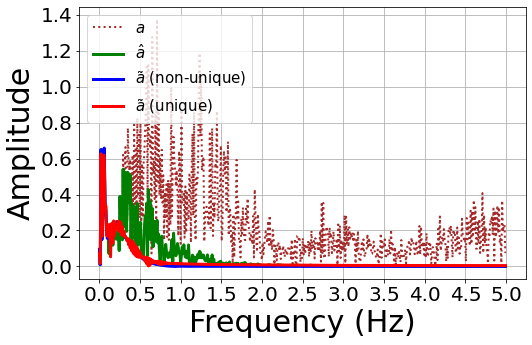

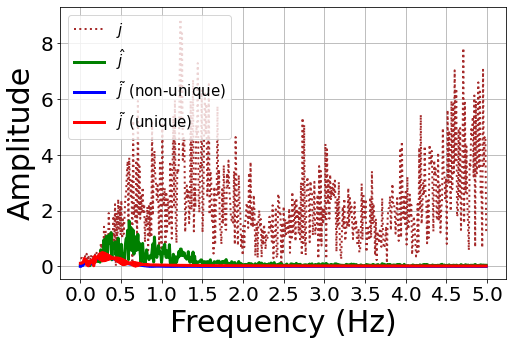

In [22]:
def displaySpectrum_smooth(data_raw, data_smooth, data_snap_no):
    import copy; from scipy.fftpack import fft
    from scipy import fftpack, arange; import matplotlib.pyplot as plt
    from pylab import plot, show, title, xlabel, ylabel, subplot
    N = len(data_raw); duration = N*0.1; dt = 0.1 #duration and sampling step(s)
    fs = 1/dt; #sampling frequency
    series_raw = copy.deepcopy(data_raw); series_smooth = copy.deepcopy(data_smooth); 
    v_hz = fft(series_smooth[:,-9],N); a_hz = fft(series_smooth[:,-8],N); j_hz = fft(series_smooth[:,-7],N); #Fourier transform
    hat_a_hz = fft(series_raw[:,-3],N); hat_j_hz = fft(series_raw[:,-2],N);
    tilde_a_hz = fft(series_smooth[:,-3],N); tilde_j_hz = fft(series_smooth[:,-2],N) #unique
    nonunique_a_hz = fft(data_snap_no[:,-3],N); nonunique_j_hz = fft(data_snap_no[:,-2],N); #non-unique
    
    frq = np.linspace(0, fs, N)
    mag_a = 2*(np.absolute(a_hz))/N; mag_hat_a = 2*(np.absolute(hat_a_hz))/N; mag_tilde_a = 2*(np.absolute(tilde_a_hz))/N; mag_nonunique_a = 2*(np.absolute(nonunique_a_hz))/N;
    mag_j = 2*(np.absolute(j_hz))/N; mag_hat_j = 2*(np.absolute(hat_j_hz))/N; mag_tilde_j = 2*(np.absolute(tilde_j_hz))/N; mag_nonunique_j = 2*(np.absolute(nonunique_j_hz))/N
    
    font2 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 30,}

    plt.figure(figsize=(8,5)); plt.xticks(np.arange(0, 5.5, 0.5)) #plt.xlim(0,100)
    plt.figure(1)
    plt.ylabel("Amplitude",font2); plt.xlabel("Frequency (Hz)",font2)
    plt.xticks(fontsize=20); plt.yticks(fontsize=20)
    plt.plot(frq[:len(frq) // 2],mag_a[:len(frq) // 2], color = "brown", linewidth=2, linestyle=':', label = "$a$");
    plt.plot(frq[:len(frq) // 2],mag_hat_a[:len(frq) // 2], color = "g", linewidth=3, label = "$\hata$"); 
    plt.plot(frq[:len(frq) // 2],mag_nonunique_a[:len(frq) // 2], color = "b", linewidth=3, label = "$\~a$ (non-unique)");
    plt.plot(frq[:len(frq) // 2],mag_tilde_a[:len(frq) // 2], color = "r", linewidth=3, label = "$\~a$ (unique)"); 
    plt.grid(); plt.legend(fontsize=15, loc = 2); plt.show()

    plt.figure(figsize=(8,5)); plt.xticks(np.arange(0, 5.5, 0.5)); #plt.ylim(0,4); 
    plt.figure(2)
    plt.ylabel("Amplitude",font2); plt.xlabel("Frequency (Hz)",font2)
    plt.xticks(fontsize=20); plt.yticks(fontsize=20)
    plt.plot(frq[:len(frq) // 2],mag_j[:len(frq) // 2], color = "brown", linewidth=2, linestyle=':', label = "$j$");
    plt.plot(frq[:len(frq) // 2],mag_hat_j[:len(frq) // 2], color = "g", linewidth=3, label = "$\hatj$"); 
    plt.plot(frq[:len(frq) // 2],mag_nonunique_j[:len(frq) // 2], color = "b", linewidth=3, label = "$\~j$ (non-unique)");
    plt.plot(frq[:len(frq) // 2],mag_tilde_j[:len(frq) // 2], color = "r", linewidth=3, label = "$\~j$ (unique)");  
    plt.grid(); plt.legend(fontsize=15, loc = 2); plt.show()

displaySpectrum_smooth(smooth_veh_l2, smooth_veh, smooth_veh_non) # raw data, unique formulation, non-unique formulation

At each time instant, we also calculate the residuals between the raw and the reconstructed positions, which can be regarded as a reflection of the detection errors

mean pos 0.25218341837272873
norm: mu 0.25218341837272873 std 0.6782367968034877 ks KstestResult(statistic=0.09264335253288303, pvalue=3.631753760654582e-08)
cauchy: mu 0.40780671220219966 std 0.4564983305914955 ks KstestResult(statistic=0.1615626800834039, pvalue=5.0196998931952825e-24)
gamma: alpha 244.7046070523005 loc -10.561877968900248 ks KstestResult(statistic=0.09634914756411961, pvalue=8.477186634751764e-09)


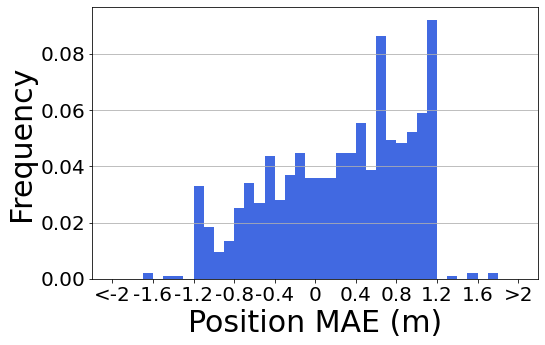

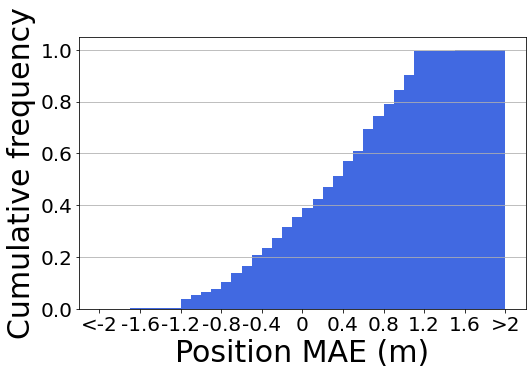

In [23]:
def pos_mae(data): #the input is the processed data
    import copy, numpy; import matplotlib.pyplot as plt; import matplotlib; from scipy.stats import norm, cauchy, chi2, kstest, gamma; import random   
    new_array = copy.deepcopy(data)
    raw_pos = new_array[:,-10]; new_pos = new_array[:,-5]; pos_mae = new_pos - raw_pos; print("mean pos",np.mean(pos_mae))
    #pos_mae = np.random.normal(0,0.4,len(data))
    font2 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 30,}
    bin = np.linspace(-2, 2, 41)
    plt.figure(figsize=(8,5)); plt.figure(1)
    plt.xticks(np.arange(-2, 2.2, 0.4), ["<-2","-1.6","-1.2","-0.8","-0.4","0","0.4","0.8","1.2","1.6",">2"], fontsize=20); plt.yticks(fontsize=20)
    plt.xlabel("Position MAE (m)", font2); plt.ylabel("Frequency", font2); #plt.ylim(0,1)
    plt.hist(pos_mae, bins=bin, color= 'royalblue', weights=[1/len(pos_mae)]*len(pos_mae)) #weights=[1/len(pos_mae)]*len(pos_mae), density = True 
    plt.show; plt.grid(axis="y"); plt.show()

    x = np.arange(-2, 2, 1/len(pos_mae)); mu_norm, std_norm = norm.fit(pos_mae); norm_curve = norm.pdf(x, mu_norm, std_norm) #fit the data with the normal distribution
    mu_c, std_c = cauchy.fit(pos_mae);   cauchy_curve = cauchy.pdf(x, mu_c, std_c) #fit with cauchy distribution
    fit_alpha, fit_loc, fit_beta = gamma.fit(pos_mae); gamma_curve = gamma.pdf(x, fit_alpha, fit_loc, fit_beta) #fit with gamma distribution
    bin_chi = np.linspace(-2, 2, 40); 
    #normal fit
    pos_mae1 = (pos_mae - mu_norm) / std_norm
    ks_norm = kstest(pos_mae1, "norm") #Kolmogorov-Smirnov test
    print("norm:" , "mu", mu_norm, "std", std_norm, "ks", ks_norm)
    #cauchy fit
    pos_mae2 = (pos_mae - mu_c) / std_c
    ks_cauchy = kstest(pos_mae2, "cauchy") #Kolmogorov-Smirnov test
    print("cauchy:" , "mu", mu_c, "std", std_c, "ks", ks_cauchy)
    #gamma fit
    ks_gamma = kstest(pos_mae, "gamma", args=(fit_alpha, fit_loc, fit_beta)) #Kolmogorov-Smirnov test
    print("gamma:" , "alpha", fit_alpha, "loc", fit_loc, "ks", ks_gamma)

    #cumulative distribution
    plt.figure(figsize=(8,5)); plt.figure(2)
    plt.xticks(np.arange(-2, 2.2, 0.4), ["<-2","-1.6","-1.2","-0.8","-0.4","0","0.4","0.8","1.2","1.6",">2"],fontsize=20 ); plt.yticks(fontsize=20)
    plt.xlabel("Position MAE (m)", font2); plt.ylabel("Cumulative frequency", font2)
    plt.hist(pos_mae, bins=bin, color= 'royalblue', cumulative = True, weights=[1/len(pos_mae)]*len(pos_mae))
    plt.show; plt.grid(axis="y"); plt.show()

pos_mae(smooth_veh_non)